In [16]:
# import necessary packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mplt
from matplotlib import rcParams
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import rc
import matplotlib.colors as colors
import cartopy.io.shapereader as shpreader
# This makes the plots look better bc they aren't the default
rc('mathtext', default='regular') 
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
rcParams['font.size'] = 12
import geopandas as gpd
import cmasher as cmr

# read in the ZIP code shapefiles using geopandas
zips = gpd.read_file('../Data/tl_2010_35_zcta510/tl_2010_35_zcta510.shp')

# This function trims a colormap so it doesn't include the last bit that gets too dark
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(cmr.torch_r, .03, 1)

In [17]:
# Read in all 4 smoke products that I am going to merge with the ZIP code file to plot
allbf = pd.read_csv('../Data/smoke/BonneZip/bigPurpleAirZip_os.csv')
# Convert date variable to pandas datetime because I will subset just for the summer
allbf['Date'] = pd.to_datetime(allbf['Date'])
# Change variable name of "Zip" to "ZCTA5CE10" to match the name of ZIP codes in the "zip" shapefile
allbf= allbf.rename(columns = {'Zip':'ZCTA5CE10', 'smokepm25': 'BFsmokepm25', 'totalpm25': 'BFtotalpm25'})
# Convert ZIP code variable to an integer so all the files merge nicely
allbf['ZCTA5CE10'] = allbf['ZCTA5CE10'].astype('int')

# Repeat for other three datasets
allbf_KOvgp = pd.read_csv('../Data/smoke/BonneZip/bigPurpleAirZip_os_KOvgp.csv')
allbf_KOvgp['Date'] = pd.to_datetime(allbf_KOvgp['Date'])
allbf_KOvgp = allbf_KOvgp.rename(columns = {'Zip':'ZCTA5CE10', 'smokepm25': 'BF_KOvgpsmokepm25', 'totalpm25': 'BF_KOvgptotalpm25'})
allbf_KOvgp['ZCTA5CE10'] = allbf_KOvgp['ZCTA5CE10'].astype('int')

kate = pd.read_csv('../Data/smoke/KateZip/AllZipSmoke_Total_os.csv')
kate['Date'] = pd.to_datetime(kate['Date'], format = '%Y-%m-%d')
kate = kate.rename(columns = {'Zip':'ZCTA5CE10', 'smokepm25': 'KATEsmokepm25', 'totalpm25': 'KATEtotalpm25'})
kate['ZCTA5CE10'] = kate['ZCTA5CE10'].astype('int')

kamal = pd.read_csv('../Data/smoke/KamalZip/Kamal_average_reformat_all_OS.csv')
kamal['Date'] = pd.to_datetime(kamal['Date'])
kamal = kamal.rename(columns = {'Zip':'ZCTA5CE10', 'smokepm25': 'KAMALsmokepm25', 'totalpm25': 'KAMALtotalpm25', 'maxsmokepm25': 'KAMALmaxsmokepm25', 'maxtotalpm25': 'KAMALmaxtotalpm25'})
kamal['ZCTA5CE10'] = kamal['ZCTA5CE10'].astype('int')


In [18]:
# Merge all files together to make one big dataset
merge1 = pd.merge(allbf, allbf_KOvgp, on = ['Date', 'ZCTA5CE10'])
merge2 = pd.merge(merge1, kate, on = ['Date', 'ZCTA5CE10'])
merge2 = merge2.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0'], axis = 1)
merge3 = pd.merge(merge2, kamal, on = ['Date', 'ZCTA5CE10'], how = 'left')
merge3 = merge3.drop(['Unnamed: 0'], axis = 1)

In [19]:
# Subset just the "warm season" aka April - August
warmseason = merge3[(merge3['Date'].dt.strftime('%Y-%m-%d') >= '2022-04-01') & (merge3['Date'].dt.strftime('%Y-%m-%d') < '2022-10-01')]
# Get the mean smoke PM2.5 per each ZIP code
warmseason = warmseason.groupby('ZCTA5CE10').mean(numeric_only = True).reset_index()
# Make sure the ZIP code variable "ZCTA5CE10" is a string bc that's what it if in the "zip" shapefile
warmseason['ZCTA5CE10'] = warmseason['ZCTA5CE10'].astype('str')
# This step merges the ZIP code shapefile we read in in the first code block with geopandas to the corresponding data
# Note: doing "warmseason.merge(zips, on = 'ZCTA5CE10)" may not work for plotting
summer22 = zips.merge(warmseason, on = 'ZCTA5CE10')

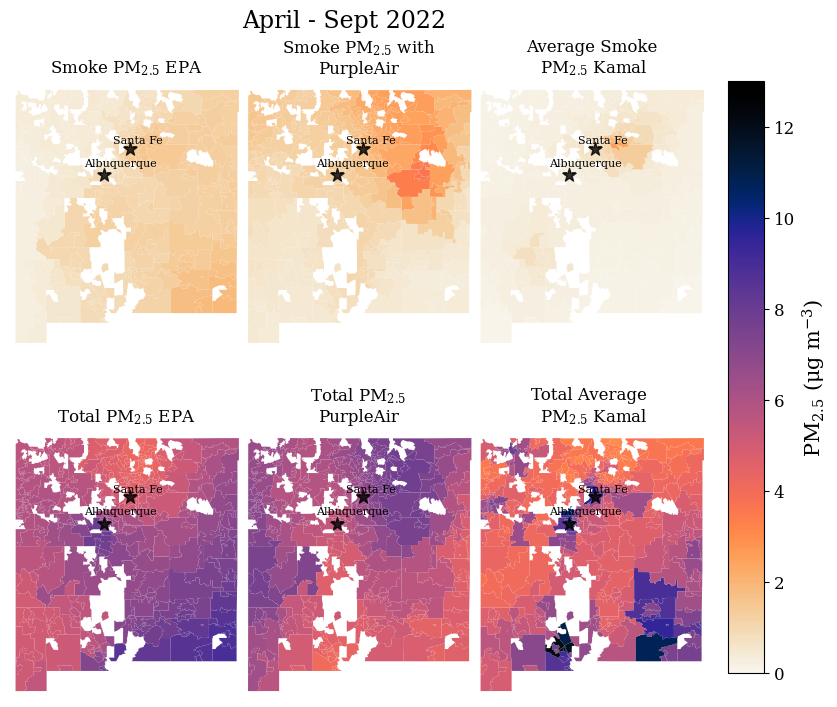

In [25]:
# This next block loops through a 3 x 2 grid of subplots to plot all of the ZIP code data
# List all of the titles
titles = ['Smoke PM$_{2.5}$ EPA', 'Smoke PM$_{2.5}$ with \nPurpleAir', 'Average Smoke\n PM$_{2.5}$ Kamal',
         'Total PM$_{2.5}$ EPA', 'Total PM$_{2.5}$ \nPurpleAir','Total Average \n PM$_{2.5}$ Kamal']
# Initiate the subplots with the number of columns, number of rows, projection, figure sizes, and the width and height space you want between plots

fig, axs = plt.subplots(ncols=3,nrows=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8),
                        gridspec_kw = {'wspace':-.5, 'hspace':.3})
# Initiate a colorbar
norm = colors.Normalize(vmin = 0, vmax= 13)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=new_cmap)
axs=axs.flatten()
# Name the overarching title for all figures
plt.suptitle('April - Sept 2022', fontsize = 17, y = .97)
# Loop through each subset and plots data from summer22 dataset
for i in range(0,6):
        axs[i].set_extent([-109.2, -102.9, 31.2, 37.2], ccrs.PlateCarree())
        if (i == 0):
            cs =summer22.plot(column = 'KATEsmokepm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
        elif (i == 1):
            summer22.plot(column = 'BFsmokepm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
#        elif (i == 2):
#            summer22.plot(column = 'BF_KOvgpsmokepm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
        elif (i == 2):
            summer22.plot(column = 'KAMALsmokepm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
        elif (i == 3):
            summer22.plot(column = 'KATEtotalpm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
        elif (i == 4):
            summer22.plot(column = 'BFtotalpm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
#        elif (i == 6):
#            summer22.plot(column = 'BF_KOvgptotalpm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
        elif (i == 5):
            summer22.plot(column = 'KAMALtotalpm25', ax = axs[i], cmap = new_cmap, legend = False, vmin = 0, vmax = 13)
            # Add the colorbar here and tell it where it should go along with the title
            cb_ax = fig.add_axes([.82,.14,.03,.74])
            ax_cbar = fig.colorbar(cbar, ax=axs[i], shrink = .8, cax = cb_ax, orientation = 'vertical')
            ax_cbar.set_label('PM$_{2.5}$ ($\mu$g m$^{-3}$)', fontsize = 15)
        # The following code is outside of the loop, so it will be applied to all subplots
        # I wrote this to add two major cities in order to orient the viewer, can definitely add others or take it out completely
        axs[i].scatter(-106.6504, 35.0844, color = 'k', s= 100, marker ="*", zorder = 15, alpha = 0.8)
        axs[i].annotate("Albuquerque", (-107.2, 35.3), fontsize = 8, zorder = 20);
        axs[i].scatter(-105.9378, 35.6870, color = 'k', s = 100, marker ="*", zorder = 15, alpha = 0.8)
        axs[i].annotate("Santa Fe", (-106.4, 35.8), fontsize = 8, zorder = 20);
        # This removes the pesky frame around the plots
        axs[i].axis('off')
        # Make sure to loop through all the titles
        axs[i].set_title(titles[i], fontsize = 12)
fig.savefig('../Figures/2022SmokeProducts')

# The following code is likely not as useful

In [21]:
summer22['PA_EPA_percentdiff'] = (summer22['KATEsmokepm25'] - summer22['BFsmokepm25'] )/ summer22['BFsmokepm25'] *100

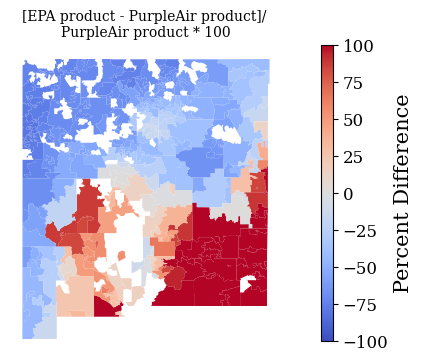

In [22]:
norm = colors.Normalize(vmin = -100, vmax= 100)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
fig = plt.figure(figsize=(4,4))
map_bounds = [-109.5, -102.5, 30.7, 37.5]
ax = plt.axes(projection = ccrs.PlateCarree())
ax.axis('off')
cs =summer22.plot(column = 'PA_EPA_percentdiff', ax = ax, vmin = -100, vmax = 100, cmap = 'coolwarm', legend = False)
cb_ax = fig.add_axes([.95,.14,.03,.74])
ax_cbar = fig.colorbar(cbar, ax=axs[i], shrink = .8, cax = cb_ax, orientation = 'vertical')
ax_cbar.set_label('Percent Difference', fontsize = 15)
ax.set_title('[EPA product - PurpleAir product]/ \nPurpleAir product * 100', fontsize = 10)
fig.savefig('../Figures/percentDiffSmokePlot.png', dpi = 300, bbox_inches = 'tight')

In [23]:
print ('April - August 2022\n')

listy = ['EPA AQS', 'PurpleAir', 'Kamal']
dfs = [kate, allbf, kamal]
smoke = ['KATEsmokepm25', 'BFsmokepm25', 'KAMALsmokepm25']
total = ['KATEtotalpm25', 'BFtotalpm25', 'KAMALtotalpm25']
for i in range(len(dfs)):
    print(listy[i])
    summer = dfs[i][dfs[i]['Date'].dt.month.isin([4, 5, 6, 7, 8])]
    oneyear = summer[summer['Date'].dt.year == 2022]
    print( round(oneyear[smoke[i]].mean(),1), '(',round(oneyear[smoke[i]].std(),1),')')
    print(round(oneyear[total[i]].mean(),1), '(',round(oneyear[total[i]].std(),1),')\n')

April - August 2022

EPA AQS
1.0 ( 2.6 )
6.3 ( 4.1 )

PurpleAir
1.4 ( 3.0 )
6.1 ( 4.1 )

Kamal
0.3 ( 0.6 )
5.7 ( 3.2 )



In [24]:
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
for i in range(len(years)):
    summer = kate[kate['Date'].dt.month.isin([4, 5, 6, 7, 8])]
    oneyear = summer[summer['Date'].dt.year == years[i]]
    print(years[i], ':')
    print('EPA AQS Smoke: ', round(oneyear['KATEsmokepm25'].mean(),1), '(',round(oneyear['KATEsmokepm25'].std(),1),')')
    print('EPA AQS Total: ', round(oneyear['KATEtotalpm25'].mean(),1), '(',round(oneyear['KATEtotalpm25'].std(),1),') \n')
print('All Years: \nEPA AQS Smoke: ', round(summer['KATEsmokepm25'].mean(),1), '(',round(summer['KATEsmokepm25'].std(),1),')')
print('EPA AQS Total: ', round(summer['KATEtotalpm25'].mean(),1), '(',round(summer['KATEtotalpm25'].std(),1),') \n')

2016 :
EPA AQS Smoke:  0.1 ( 0.8 )
EPA AQS Total:  4.9 ( 2.6 ) 

2017 :
EPA AQS Smoke:  0.3 ( 1.1 )
EPA AQS Total:  5.2 ( 2.4 ) 

2018 :
EPA AQS Smoke:  0.6 ( 2.4 )
EPA AQS Total:  6.8 ( 5.5 ) 

2019 :
EPA AQS Smoke:  0.3 ( 1.3 )
EPA AQS Total:  4.9 ( 2.7 ) 

2020 :
EPA AQS Smoke:  0.8 ( 2.4 )
EPA AQS Total:  5.9 ( 3.1 ) 

2021 :
EPA AQS Smoke:  1.6 ( 4.5 )
EPA AQS Total:  7.3 ( 5.0 ) 

2022 :
EPA AQS Smoke:  1.0 ( 2.6 )
EPA AQS Total:  6.3 ( 4.1 ) 

All Years: 
EPA AQS Smoke:  0.7 ( 2.5 )
EPA AQS Total:  5.9 ( 3.9 ) 

